# <center> Homework 5

### Summary
In this report we will mainly focus on how to extract data using new methods such as REST and web scraping and how to apply it on websites instead of working with csv files as we've been doing for the recent homework assigments. We will look at what category won the most nobel prizes and present it in wordcloud. 

We will also perform web scraping on a website with books and review these in a DataFrame and learn how to apply this method for any general website one might be intrested to do it on.


### REST API

This code fetches data from the Nobel Prize API to gather information about Physics laureates. It extracts the motivations (reasons for the awards) from the API response, combines them into a single text, and then creates a WordCloud visualization. This WordCloud highlights the most common words found in the motivations, while excluding stopwords for clarity. Finally, the WordCloud is displayed using a graphical interface.

In [ ]:
import requests 
import json as json

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Making a get requests to URI
url = 'https://api.nobelprize.org/2.1/nobelPrizes'
params = {"sort" : "desc", "nobelPrizeCategory" : "phy"}
r = requests.get(url, params)
data = r.json()

data_list = data["nobelPrizes"]
data_list[0]

{'awardYear': '2024',
 'category': {'en': 'Physics', 'no': 'Fysikk', 'se': 'Fysik'},
 'categoryFullName': {'en': 'The Nobel Prize in Physics',
  'no': 'Nobelprisen i fysikk',
  'se': 'Nobelpriset i fysik'},
 'dateAwarded': '2024-10-08',
 'prizeAmount': 11000000,
 'prizeAmountAdjusted': 11000000,
 'links': [{'rel': 'nobelPrize',
   'href': 'https://api.nobelprize.org/2/nobelPrize/phy/2024',
   'action': 'GET',
   'types': 'application/json'}],
 'laureates': [{'id': '1037',
   'knownName': {'en': 'John J. Hopfield'},
   'fullName': {'en': 'John J. Hopfield'},
   'portion': '1/2',
   'sortOrder': '1',
   'motivation': {'en': 'for foundational discoveries and inventions that enable machine learning with artificial neural networks',
    'se': 'för grundläggande upptäckter och uppfinningar som möjliggör maskininlärning med artificiella neuronnätverk'},
   'links': [{'rel': 'laureate',
     'href': 'https://api.nobelprize.org/2/laureate/1037',
     'action': 'GET',
     'types': 'application/

Creating a list for the motivations and then making a wordcloud out of them.

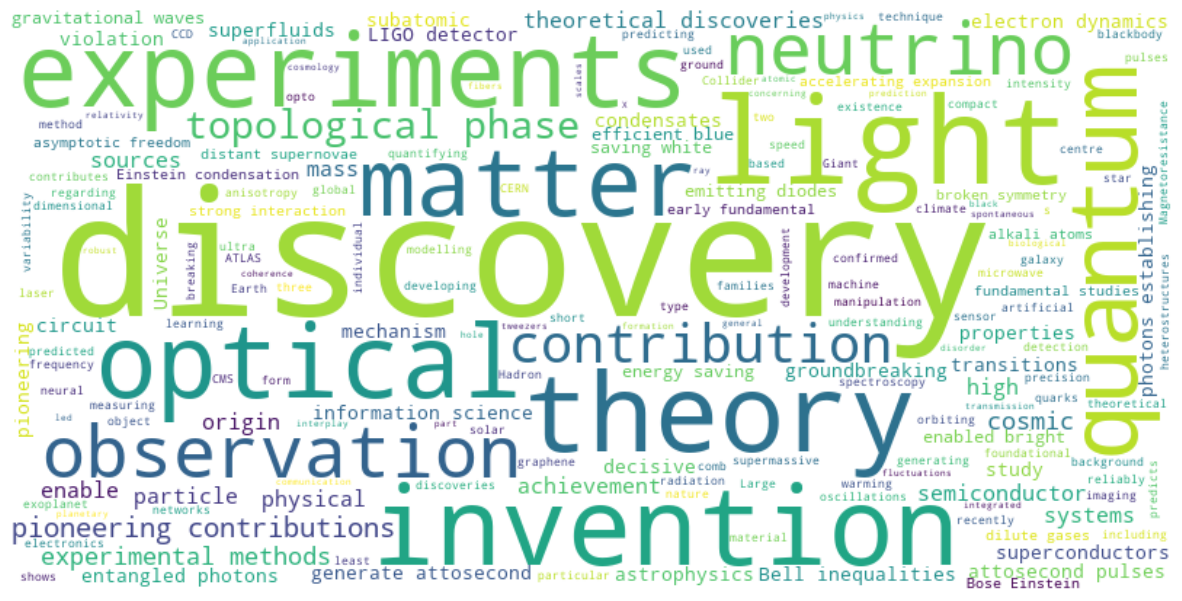

In [8]:
motivations = []

# Extract motivations from the data list
for prize in data_list:
    if 'laureates' in prize:
        for laureate in prize['laureates']:
            # Get the motivation text (if available) in English
            motivation_text = laureate.get('motivation', {}).get('en')
            if motivation_text:
                motivations.append(motivation_text)

# Define stopwords to exclude from the WordCloud
stopwords_set = set(STOPWORDS)

# Combine all motivations into a single text
motivations_combined = " ".join(motivations)

# Create a WordCloud object
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords_set
).generate(motivations_combined)

# Display the generated WordCloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As we can see the award went to the people that made discovery's for the most part and is the most common reason. But there are also prizes that was awarded for people that made experiments and new theory's.

### Web Scraping data

For this task we will be performing something called web scraping with essentialy means that the user is extracting data from a website and in our case we will be performing it on a website that displays various books. 

After reviewing the website we will do a web scrape on 20 books for each page and it's in total 3 pages. So in preparation we will create some functions to then create a DataFrame of all the values and books.

In [6]:
import requests
from bs4 import BeautifulSoup

def extract_table_data(soup):
    """
    Find the UPC and price from the table.
    """
    # Find all table rows in the HTML
    table_rows = soup.find_all("tr")
    
    # Initialize variables to store UPC and price values
    product_upc = None
    product_price = None
    
    # Iterate through each row in the table
    for row in table_rows:
        # Extract the header text (e.g., "UPC") and the corresponding data value
        header_text = row.find('th').text.strip()
        data_value = row.find('td').text.strip()
        
        # Check if the header matches "UPC" and store the value
        if header_text == 'UPC':
            product_upc = data_value
        # Check if the header matches "Price (excl. tax)" and store the value
        elif header_text == 'Price (excl. tax)':
            product_price = data_value
    
    # Return the extracted UPC and price
    return product_upc, product_price

def extract_name_and_rating(soup):
    """
    Find the product name and star rating.
    """
    # Extract the product name from the <h1> tag
    product_name = soup.find('h1').text
    
    # Find the star rating element by its class name
    rating_element = soup.find(class_='star-rating')
    
    # Extract the star rating class value (e.g., "Three", "Four")
    star_rating = rating_element['class'][1] if rating_element else None
    
    # Return the extracted product name and star rating
    return product_name, star_rating

For this section of code we are going to iterate thru the pages and all books. The result will be presented in a DataFrame using the library pandas. 

In [7]:
# Base URL of the website
base_url = "https://books.toscrape.com/"

# List to store scraped book data
book_records = []

# Iterate over the first 3 pages of the catalogue
for page_number in range(1, 4):
    # Construct the URL for the current page
    page_url = base_url + f"catalogue/page-{page_number}.html"
    response = requests.get(page_url)
    page_soup = BeautifulSoup(response.content, 'html.parser')

    # Find all book links on the page
    books_on_page = page_soup.find_all('a', href=True, title=True)

    # Iterate over each book link
    for book in books_on_page:
        # Construct the URL for the book's details page
        book_relative_link = book['href']
        book_details_url = base_url + "catalogue/" + book_relative_link

        # Request the book's details page
        book_response = requests.get(book_details_url)
        book_soup = BeautifulSoup(book_response.content, 'html.parser')

        # Extract relevant information using the helper functions
        product_name, star_rating = extract_name_and_rating(book_soup)
        product_upc, product_price = extract_table_data(book_soup)

        # Append the extracted data to the records list
        book_records.append({
            'UPC': product_upc,
            'Title': product_name,
            'Price': product_price,
            'Rating': star_rating
        })

# Create a DataFrame from the scraped data
books_df = pd.DataFrame(book_records)

# Display the DataFrame
books_df

,UPC,Title,Price,Rating
0,a897fe39b1053632,A Light in the Attic,£51.77,Three
1,90fa61229261140a,Tipping the Velvet,£53.74,One
2,6957f44c3847a760,Soumission,£50.10,One
3,e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five
5,f77dbf2323deb740,The Requiem Red,£22.65,One
6,2597b5a345f45e1b,The Dirty Little Secrets of Getting Your Dream...,£33.34,Four
7,e72a5dfc7e9267b2,The Coming Woman: A Novel Based on the Life of...,£17.93,Three
8,e10e1e165dc8be4a,The Boys in the Boat: Nine Americans and Their...,£22.60,Four
9,1dfe412b8ac00530,The Black Maria,£52.15,One


Note that it's in total 60 points and not 59 due to the first data point being referred to datapoint zero and not one. This is the desired result that we want to obtain and this gives one a good intuiton on how to apply this in the world. 